# Mega StratBuilder

This is the neatened StratBuilder code with some of my annoying essays. The main draw of this code is that it houses the components to interpret cross-stream and down stream sections, you just have to declare it. This code works by importing the full grids from NAYS2DH as a NumPy array and pulling out the model results for a specified location. It basically functions in 3 parts:
1. Data import
2. Plotting
3. Exports and some preliminary statistics

## Declare cross-stream or downstream flags

In [10]:
sec_flag = input('What kinds of sections are you plotting: XS or DWN: ')

What kinds of sections are you plotting: XS or DWN:  XS


## Import packages

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcol

import matplotlib.pyplot as plt
import copy

from os import listdir
from os.path import isfile, join
from scipy import interpolate
from scipy.interpolate import griddata

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

##### Setting up all the aesthetics:
Import new colormapas, reverse them, create plot style (font, font size, etc)

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

### Important model parameters that might be used in calculation + import data:
At the moment (March 22) the only things we need to set are:
1. cross-section location (I and J)
1. DV flag (0 for none, 1 for variable)
1. adjustment time (60 for the 2 hour strat given an average adj time of 120 hours)

Need to expand and change cell width and length if not using a 4x10 cell size!

In [3]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds
variabd = 0# int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = 65 #int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}-flux.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

print(f'/Volumes/SAF_Data/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

# iloc = int(input('I-location is '))#location of the section along i axis
# jloc = 0#int(input('j-location is '))#location of the secion along j axis


/Volumes/SAF_Data/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-2hour-flux.npy


### More model domain set up

In [6]:
cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'

In [7]:
###define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 12, 382)


In [8]:
num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s
end_time = end_t
print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  382
Shape of data used to plot: (26026, 12, 382)


### Make many wheeler diagrams ONLY

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


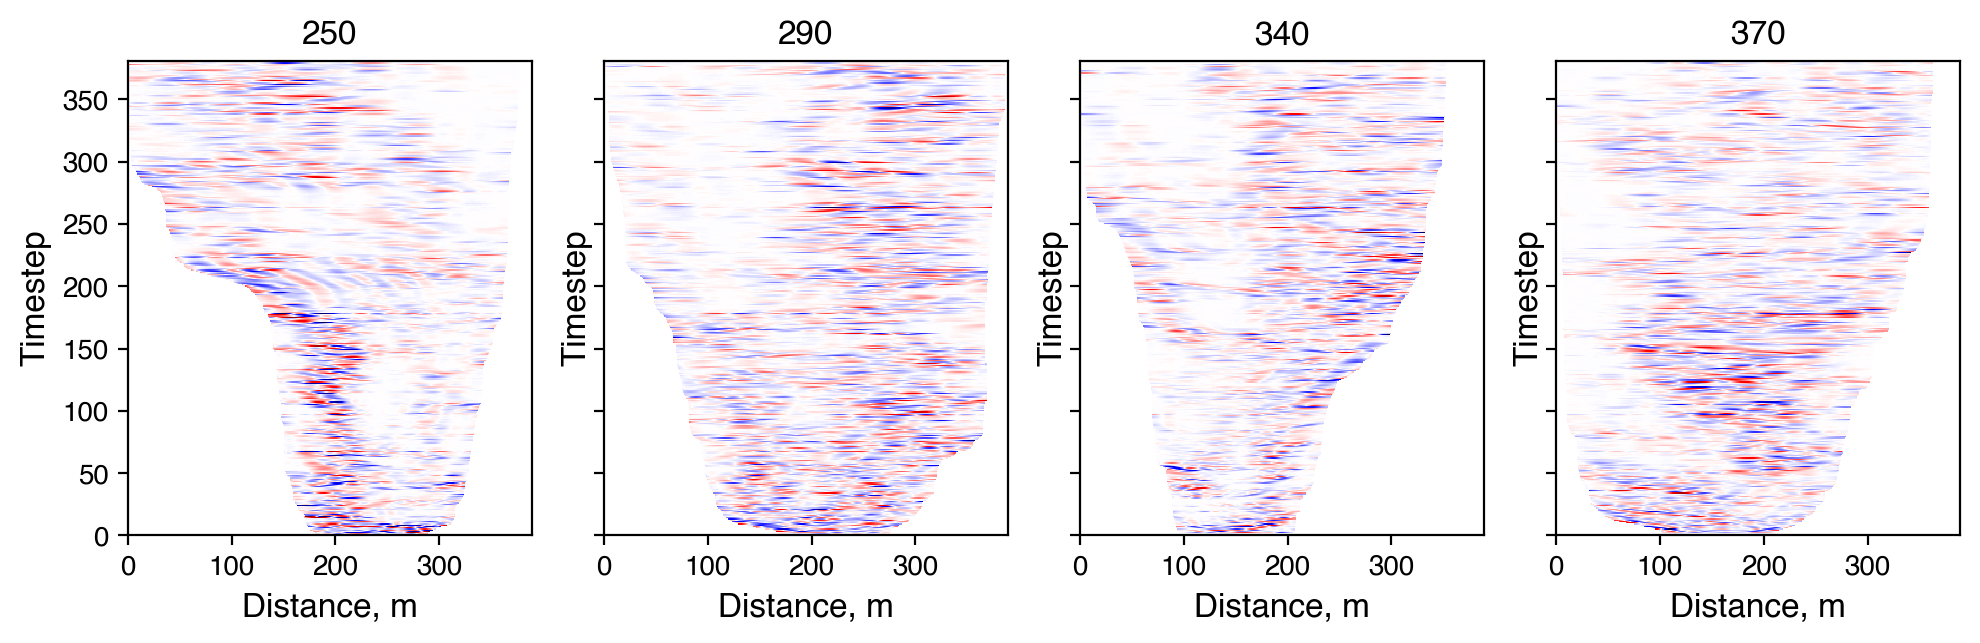

In [11]:
ilocation = [250, 290, 340, 370] ## set the cross-section locations you want wheeler diagrams for
# ilocation = [340]
bar_lambda = 25 ## half wavelength of bar width to average over for the average wheelet diagram
turntime = 13
avg_burial = 21 ##average burial timescale for bars from 3000-5000km along centreline
    
# plt.style.use('dark_background')?

ehfig, ehax = plt.subplots(len(ilocation)//4, 4, dpi = 200, sharex = True, sharey= True, figsize = (10, 15), tight_layout = True, squeeze = True)

ehax = ehax.ravel()
diff_llim, diff_ulim = np.round(np.quantile(datamaster[:, 7, :], (.01, .75)), 1) 

for iloc, ehax in zip(ilocation, ehax):
    modelrun = f'{nickname}-{idf}-{iloc}'

    remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
    data = np.delete(datamaster, remove_ilocs[0], axis=0)
    for i in range (0, num_timesteps):
        data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]
    stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion

    stratigraphy_idx = stratigraphy.copy()

    runtime = len(stratigraphy)
    
    xposition =  stratigraphy.copy()

    in_section = np.where(datamaster[:, 0, -1]==iloc)
    in_section = in_section[0]
    bankpos = datamaster[:, 3, :][in_section]
    
    rightbank = bankpos.min() ###negativee
    leftbank = bankpos.max() #positive
    
    xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
    
    xy_strat[:] = np.nan

    for time in range (0, data.shape[2]): #TIME
    
        stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 
        ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
        xposition[time, :] = ypos

    stratigraphy_idx = stratigraphy.copy()

    for t in range (0, end_t):
        for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
            x = int(np.floor(x)) #rounding down positions, making integers so can use as index
            xy_strat[t, x] = stratigraphy[t, idx]

    xy_topo = np.empty_like(xy_strat)
    xy_topo[:] = np.nan
    for t in range (0, end_t):
        length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
        pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
        dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)

        stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
        fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
        xy_topo[t, dataint] = fx(dataint) #reassign strat

    stratcondition = np.zeros_like(xy_topo)
    stratcondition[:] = np.nan
    ages = np.empty_like(xy_strat)

    erosurf = np.empty([end_t, xy_topo.shape[1]])
    erosurf[:] = np.nan

    strat = copy.deepcopy(xy_topo)

    halfwidth=25

    for time in range (0, end_t):

        for space in range (0, xy_topo.shape[1]):
            preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
            willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
            xy_topo[willerode, space] = xy_topo[time, space]
            ages[willerode, space] = time

    if sec_flag == 'XS':
        for i in range (end_t-2, -1, -1):
            fillinx = np.where(np.isnan(xy_topo[i, :]))
            xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
            stratcondition[i, fillinx] = 1

            fillinstrat = np.where(np.isnan(strat[i, :]))
            # strat[i, fillinstrat] = strat[i+1, fillinstrat]

    thickness = strat[1:]-strat[:-1]

    start_time = 0 #would be start of model run
    end_time_int = num_timesteps-1 #would be end of model run

    tim_int = range(start_time,end_time) #range of time
    xdat_int = np.arange(0, xy_topo.shape[1]) #position
    ydat_int = [xy_topo[t] for t in tim_int] #stratigraphy/elevation @ position

    diffs_nanzero = copy.deepcopy(thickness)
    # diffs_nanzero[np.isnan(thickness)] = 0
    difference = np.cumsum(np.ma.masked_invalid(diffs_nanzero), axis = 0)
    
    midnorm = mcol.SymLogNorm(linthresh = 0.01, vmin = -10, vmax = 10)
    midnorm_col = mcol.TwoSlopeNorm(vcenter = 0, vmin = -3, vmax = 3)
    
    absol = ehax.pcolormesh(thickness, cmap = 'seismic_r', norm = mcol.TwoSlopeNorm(vcenter = 0, vmin = np.nanmax(thickness)*-1, vmax = np.nanmax(thickness)), shading = 'flat')#, snap = True)

    ehax.set_title(iloc)
    ehax.set_ylabel('Timestep', fontsize = 12)
    ehax.set_xlabel('Distance, m', fontsize = 12)
    ehax.set_aspect(1.2)
    
## Add centroids for visibility    
#     for ts in range(end_t-1):

#         rnd = np.round(thickness[ts, :], 2)
#         # xpossies = np.where(np.isclose(rnd, np.nanmin(rnd), atol = 0.05))[0]
#         xpossies = np.where(rnd==np.nanmin(rnd))[0]
#         ehax.scatter(xpossies, np.ones(len(xpossies))*ts, c = 'k', marker = '.', s = 5, alpha = 0.25)
        
# axins = inset_axes(
#     ehax,
#     width="5%",  # width: 5% of parent_bbox width
#     height="50%",  # height: 50%
#     loc="lower left",
#     bbox_to_anchor=(1.05, 0., 1, 1),
#     bbox_transform=ehax.transAxes,
#     borderpad=0,
# # )
# ehfig.colorbar(absol, ax = ehax, shrink = 0.5, aspect = 10)

# ehfig.colorbar(absol, cax = axins, label = 'Thickness Change, m')
# plt.savefig(savefilesto+'ero_dep_wheeler/MultiSection1.png', dpi = 200, transparent = True)